# Document comparer

Azure OpenAI & Azure Document Intelligence to compare documents

## Process
- Generate embeddings for both document 1 and document 2.
- Calculate the cosine similarities for each chunk of document 1 and document 2.
- Compare all the cosine similarities.
- If any differences are found, print the differences from the documents.
- If all cosine similarities are equal to 1, then both documents are identical.


18-Sept-2024

<img src="document_comparer.jpg">

In [43]:
import langchain
import matplotlib.pyplot as plt
import numpy as np
import openai
import os
import pandas as pd
import platform
import psutil
import shutil
import sys
import time
import tiktoken

from dotenv import load_dotenv
from IPython.display import FileLink
from langchain.text_splitter import MarkdownHeaderTextSplitter
from langchain_community.document_loaders import AzureAIDocumentIntelligenceLoader
from numpy.linalg import norm
from openai import AzureOpenAI

In [44]:
def print_system_info():
    """
    System info
    """
    print("System info\n")
    print("-" * 100)
    print(f"Uname: {platform.uname()}")
    print(f"Machine: {platform.machine()}")
    print(f"Node: {platform.node()}")
    print(f"Processor: {platform.processor()}")
    print(f"Release: {platform.release()}")
    print(f"System: {platform.system()}")
    print(f"Version: {platform.version()}")
    print(f"Platform: {platform.platform()}")
    print("-" * 100)
    print(f"Python version: {sys.version}")
    print(f"Python version info: {sys.version_info}")
    print("-" * 100)
    print(f"Number of physical cores: {psutil.cpu_count(logical=False)}")
    print(f"Number of logical cores: {psutil.cpu_count(logical=True)}")
    print(f"Current CPU frequency: {psutil.cpu_freq().current} MHz")
    print(f"Min CPU frequency: {psutil.cpu_freq().min} MHz")
    print(f"Max CPU frequency: {psutil.cpu_freq().max} MHz")
    print("-" * 100)
    virtual_memory = psutil.virtual_memory()
    print(f"Total memory: {virtual_memory.total / (1024 ** 3):.2f} GB")
    print(f"Available memory: {virtual_memory.available / (1024 ** 3):.2f} GB")
    print(f"Used memory: {virtual_memory.used / (1024 ** 3):.2f} GB")
    print(f"Memory percentage: {virtual_memory.percent}%")
    print("-" * 100)
    disk_total, disk_used, disk_free = shutil.disk_usage("/")
    gb_total = disk_total / (1024**3)
    gb_used = disk_used / (1024**3)
    gb_free = disk_free / (1024**3)
    print(f"Total storage:\t{gb_total:.2f} GB")
    print(f"Used storage:\t{gb_used:.2f} GB")
    print(f"Free storage:\t{gb_free:.2f} GB")
    free_storage_pct = (gb_free / gb_total) * 100
    print(f"Free storage:\t{free_storage_pct:.2f}%")
    print("-" * 100)


print_system_info()

System info

----------------------------------------------------------------------------------------------------
Uname: uname_result(system='Windows', node='OBELCHAILLM', release='10', version='10.0.22631', machine='AMD64')
Machine: AMD64
Node: OBELCHAILLM
Processor: Intel64 Family 6 Model 140 Stepping 1, GenuineIntel
Release: 10
System: Windows
Version: 10.0.22631
Platform: Windows-10-10.0.22631-SP0
----------------------------------------------------------------------------------------------------
Python version: 3.11.9 (main, Jul 25 2024, 21:53:06) [MSC v.1929 64 bit (AMD64)]
Python version info: sys.version_info(major=3, minor=11, micro=9, releaselevel='final', serial=0)
----------------------------------------------------------------------------------------------------
Number of physical cores: 4
Number of logical cores: 8
Current CPU frequency: 2995.0 MHz
Min CPU frequency: 0.0 MHz
Max CPU frequency: 2995.0 MHz
--------------------------------------------------------------------

## 1. Settings

In [45]:
print(f"Python version: {sys.version}")
print(f"OpenAI version: {openai.__version__}")
print(f"Langchain version: {langchain.__version__}")

Python version: 3.11.9 (main, Jul 25 2024, 21:53:06) [MSC v.1929 64 bit (AMD64)]
OpenAI version: 1.46.0
Langchain version: 0.3.0


In [46]:
load_dotenv("azure.env")

# Azure Document Intelligence
AZURE_DOCUMENT_INTELLIGENCE_ENDPOINT: str = os.getenv("AZURE_DOCUMENT_INTELLIGENCE_ENDPOINT")
AZURE_DOCUMENT_INTELLIGENCE_KEY: str = os.getenv("AZURE_DOCUMENT_INTELLIGENCE_KEY")

# Azure OpenAI
AOAI_API_ENDPOINT: str = os.getenv("AZURE_OPENAI_API_ENDPOINT")
AOAI_API_KEY: str = os.getenv("AZURE_OPENAI_API_KEY")

In [47]:
# Azure OpenAI embeddings model
# Documentation: https://learn.microsoft.com/en-us/azure/ai-services/openai/concepts/models#embeddings

# Use the deployed model name from your Azure OpenAI Studio for the embeddings model
AOAI_EMBEDDINGS_MODEL: str = "text-embedding-3-large"

# API version (subject to change in the future)
AOAI_API_VERSION: str = "2024-06-01"

## 2. Functions

In [48]:
def get_ocr(document_file):
    """
    Extracts all text from a document file using Azure Document Intelligence.

    This function processes the given document file using Azure Document Intelligence's
    prebuilt layout model with high-resolution OCR analysis features. It measures the 
    time taken to process the document and prints the elapsed time.

    Parameters:
        document_file (str): The path to the document file to be processed.

    Returns:
        document: The processed document containing extracted text and other information.
    """
    start = time.time()

    loader = AzureAIDocumentIntelligenceLoader(
        file_path=document_file,  # File to process
        api_key=AZURE_DOCUMENT_INTELLIGENCE_KEY,  # Key
        api_endpoint=AZURE_DOCUMENT_INTELLIGENCE_ENDPOINT,  # Endpoint
        api_model="prebuilt-layout",  # Prebuilt layout of Azure Doc Intelligence
        analysis_features=["ocrHighResolution"],  # To get OCR High resolution
    )

    # Loading the document
    print("Processing the document with Azure Document Intelligence...")
    document = loader.load()

    # End
    elapsed = time.time() - start
    print("\nDone")
    print(f"Elapsed time = {elapsed // 60:.0f} minutes and {elapsed % 60:.0f} seconds")

    return document

In [49]:
def get_semantic_chunks(document):
    """
    Splits a markdown document into chunks based on specified headers and prints the number of chunks.
    This will use Azure Document Intelligence. This code snippet defines the headers to split on, 
    initializes a MarkdownHeaderTextSplitter with these headers, and splits the content of the first
    document in the provided list. It then prints the length of the resulting chunks.

    Variables:
        headers_to_split_on (list): A list of tuples where each tuple contains a markdown header and its description.
        text_splitter (MarkdownHeaderTextSplitter): An instance of MarkdownHeaderTextSplitter initialized with 
        the specified headers.
        docs_string (str): The content of the first document in the provided list.
        chunks (list): A list of chunks obtained by splitting the document content.
    """
    # Headers definition
    headers_to_split_on = [
        ("#", "Header 1"),
        ("##", "Header 2"),
        ("###", "Header 3"),
        ("####", "Header 4"),
        ("#####", "Header 5"),
    ]

    # Text split based on the headers
    text_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on)
    docs_string = document[0].page_content
    chunks = text_splitter.split_text(docs_string)

    print(f"Length of chunks for document1 = {len(chunks)}")

    return chunks

In [50]:
def print_chunks(chunks):
    """
    Prints the content and length of each chunk in the provided list of chunks.

    This function iterates through the list of chunks, prints the index, length, and content of each chunk.
    It also collects the lengths and contents of the chunks into separate lists and returns them.

    Parameters:
        chunks (list): A list of chunk objects, each containing a 'page_content' attribute.

    Returns:
    tuple: A tuple containing two lists:
        - chunk_size_list (list): A list of integers representing the lengths of the chunks.
        - chunks_doc (list): A list of strings representing the content of the chunks.
    """
    chunk_size_list = []
    chunks_doc = []

    for idx, chunk in enumerate(chunks, start=1):
        print(f"----- Chunk {idx} -----\nLength of chunk = {len(chunk.page_content)}\n")
        print(f"\033[1;34m{chunk.page_content}\033[0m\n")
        chunk_size_list.append(len(chunk.page_content))
        chunks_doc.append(chunk.page_content)

    return chunk_size_list, chunks_doc

In [51]:
def get_embeddings(text):
    """
    Generates embeddings for the given text using Azure OpenAI.

    This function creates embeddings for the input text using the specified Azure OpenAI model.
    It initializes the Azure OpenAI client with the provided API key, version, and endpoint,
    and then generates the embeddings by calling the embeddings.create method.

    Parameters:
        text (str): The input text for which embeddings need to be generated.

    Returns:
        list: A list representing the embedding of the input text.
    """
    # Azure OpenAI client
    aoai_client = AzureOpenAI(api_key=AOAI_API_KEY,
                              api_version=AOAI_API_VERSION,
                              azure_endpoint=AOAI_API_ENDPOINT)

    # Get embedddings
    response = aoai_client.embeddings.create(
        input=text,
        model=AOAI_EMBEDDINGS_MODEL,
    )

    return response.data[0].embedding

In [52]:
def get_cosine_similarity(vector1, vector2):
    """
    Calculates the cosine similarity between two vectors using Numpy.

    This function computes the cosine similarity between two input vectors, which is a measure
    of the cosine of the angle between them. 
    It is calculated as the dot product of the vectors divided by the product of their
    magnitudes (Euclidean norms).

    Parameters:
        vector1 (list): A list of numerical values representing the first vector.
        vector2 (list): A list of numerical values representing the second vector.

    Returns:
        float: The cosine similarity between the two vectors.
    """
    cosine_similarity = np.dot(vector1, vector2) / (norm(vector1) * norm(vector2))

    return cosine_similarity

In [53]:
def get_the_difference(string1, string2):
    """
    Compare two strings and return the words that are different along
    with their previous and next words.

    Args:
        string1 (str): The first string to compare.
        string2 (str): The second string to compare.

    Returns:
        tuple: A tuple containing two strings. Each string includes the previous word,
        the different word, and the next word.
        If there are no differences, returns None.
    """
    words1 = string1.split()
    words2 = string2.split()

    for i, (word1, word2) in enumerate(zip(words1, words2)):
        if word1 != word2:
            prev_word = words1[i - 1] if i > 0 else None
            next_word = words1[i + 1] if i < len(words1) - 1 else None
            item1 = f"{prev_word} {word1} {next_word}"
            item2 = f"{prev_word} {word2} {next_word}"
            return item1, item2

    return None

In [54]:
def get_df_highlight_values(val):
    """
    Highlights values in a DataFrame.

    This function applies a background color to values in a DataFrame.
    If the value is less than 1, it will be highlighted in red.

    Parameters:
        val (float): The value to be checked and highlighted.

    Returns:
        str: A string representing the CSS style for background color.
    """
    colorformat = "red" if val < 1 else "lime"

    return f"background-color: {colorformat}"

In [55]:
def get_nb_tokens(text):
    """
    Computes the number of tokens in a given text using the specified model's encoding.

    Parameters:
    text (str): The input text for which the number of tokens is to be computed.

    Returns:
    int: The number of tokens in the input text.
    """
    encoding = tiktoken.encoding_for_model(AOAI_EMBEDDINGS_MODEL)
    nb_tokens = len(encoding.encode(text))

    return nb_tokens

In [56]:
def document_comparer(document_file1, document_file2, chunks_doc1, chunks_doc2):
    """
    Compares two documents by their chunks and prints the comparison results.

    This code snippet compares the chunks of two documents to determine if they are similar or different.
    It prints the comparison results, including the number of chunks and the cosine similarity of each chunk.
    If the number of chunks is different, it flags the documents as different. Otherwise, it calculates the
    cosine similarity for each chunk and flags any differences.

    Variables:
        flag_list (list): A list to store flags indicating different chunks.
        document_file1 (str): The file name of the first document.
        document_file2 (str): The file name of the second document.
        chunks_doc1 (list): A list of chunks from the first document.
        chunks_doc2 (list): A list of chunks from the second document.
        flag_simil_list (list): A list to store flags indicating similarity or difference.

    Returns:
        tuple: A tuple containing the result ("IDENTICAL" or "DIFFERENT") and the list of flags indicating
        different chunks.
    """
    # Init
    df = pd.DataFrame(columns=['CHUNK_ID', 'DOC_1', 'SIZE_1', 'TOKENS_1', 'DOC_2',
                               'SIZE_2', 'TOKENS_2', 'SIMILARITY'])
    flag_list = []

    print(f"Comparing documents {document_file1} and {document_file2}:\n")

    # Error if number of chunks are different
    if len(chunks_doc1) != len(chunks_doc2):
        print("\033[1;31m", end="")
        print("Documents are different since the number of chunks is not the same:")
        print(f"- Number of chunks for {document_file1} = {len(chunks_doc1)}")
        print(f"- Number of chunks for {document_file2} = {len(chunks_doc2)}")
        
        flag = "DIFFERENT"
        flag_list.append(flag)

    # When we have the same number of chunks for the 2 documents
    else:
        for idx in range(len(chunks_doc1)):
            # Embeddings
            embeddings_doc1 = get_embeddings(chunks_doc1[idx])
            embedding2_doc2 = get_embeddings(chunks_doc2[idx])
            
            # Get Cosine similarity
            cos_simil = round(get_cosine_similarity(embeddings_doc1, embedding2_doc2), 4)

            # Testing Cosine Similarity
            if cos_simil < 1:
                print("\033[1;31;91m", end="")
                print(f"\nChunks {idx+1:05}/{len(chunks_doc1)} are different (cosine similarity = {cos_simil})")
                flag = f"{idx+1}"
                flag_list.append(flag)
                separator = "*" * 110
                
                # Get the different terms from both documents
                item1, item2 = get_the_difference(chunks_doc1[idx], chunks_doc2[idx])
                # Print results
                print(f"\n[Differences detected]")
                print(f"In {document_file1}: {item1}")
                print(f"In {document_file2}: {item2}")
                print("\033[1;31;30m")
                print(f"[Chunks]")
                print(f"\nChunk {idx+1:05}/{len(chunks_doc1)} for {document_file1}:\n\n{chunks_doc1[idx]}\n\n{separator}\n\nChunk {idx+1:05}/{len(chunks_doc1)} for {document_file2}:\n\n{chunks_doc2[idx]}\n")
            
            else:
                print("\033[1;34m", end="")
                print(f"Chunks {idx+1:05}/{len(chunks_doc1)} are similar (cosine similarity = 1)")

            # Updating the df
            size1 = len(chunks_doc1[idx])
            size2 = len(chunks_doc2[idx])
            tokens1 = get_nb_tokens(chunks_doc1[idx])
            tokens2 = get_nb_tokens(chunks_doc2[idx])
            df.loc[len(df)] = {'CHUNK_ID': idx+1, 'SIMILARITY': cos_simil,
                               'DOC_1': document_file1, 'SIZE_1': size1, 'TOKENS_1': tokens1,
                               'DOC_2': document_file2, 'SIZE_2': size2, 'TOKENS_2': tokens2}

        print("\033[1;31;30m")
        print("Conclusion:")
        print("\033[1;31;32m", end="")
        color_code = "\033[1;31;32m" if not flag_list else "\033[1;31;91m"
        status = "Documents are identical." if not flag_list else "Documents are not identical."
        print(f"{color_code}{status}")

    result = "IDENTICAL" if not flag_list else "DIFFERENT"

    return result, df

In [57]:
def get_plot_results(df):
    """
    Plots the cosine similarity values for all the chunks in the given DataFrame.
    This will print as well the weighted average of similarity using the tokens.
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing the cosine similarity values with a column named 'SIMILARITY'.
    """
    plt.figure(figsize=(10, 3))
    plt.bar(df['CHUNK_ID'], df['SIMILARITY'], color='green')

    # Highlight values < 1 in red
    below_one = df[df['SIMILARITY'] < 1]

    plt.bar(below_one['CHUNK_ID'],
            below_one['SIMILARITY'],
            color='red',
            label='Similarity < 1')
    plt.title('Similarity between chunks', fontsize=13)
    plt.xlabel('Chunk', fontsize=10)
    plt.ylabel('Cosine similarity', fontsize=10)
    plt.xticks(df['CHUNK_ID'], fontsize=7)
    plt.yticks(fontsize=10)
    plt.grid(axis='y', linestyle='--')
    plt.show()

    nb_diff_chunks = len(df[df['SIMILARITY'] < 1])

    if nb_diff_chunks > 0:
        pd.set_option('display.precision', 10)
        print(f"Number of different chunk(s) = {nb_diff_chunks}\n")
        print(df[df['SIMILARITY'] < 1].to_string(index=False))

        # Weighted average mean
        weighted_average_similarity = (
            df['SIMILARITY'] * df['TOKENS_1']).sum() / df['TOKENS_1'].sum()
        print(
            f"\nWeighted average of SIMILARITY = {weighted_average_similarity}"
        )

    else:
        weighted_average_similarity = 1

    return weighted_average_similarity

## 3. Running the chunking and embeddings

### Documents files

In [58]:
DOCS_DIR = "documents"

os.makedirs(DOCS_DIR, exist_ok=True)

In [59]:
!ls $DOCS_DIR -lh

'ls' n'est pas reconnu en tant que commande interne
ou externe, un programme ex�cutable ou un fichier de commandes.


In [60]:
LINK1 = FileLink(path=os.path.join(DOCS_DIR, 'Doc1.pdf'))
LINK1

c:\Users\chaillm\Documents\Work\training\documents\Doc1.pdf

In [61]:
LINK2 = FileLink(path=os.path.join(DOCS_DIR, 'Doc2.pdf'))
LINK2

c:\Users\chaillm\Documents\Work\training\documents\Doc2.pdf

In [62]:
LINK3 = FileLink(path=os.path.join(DOCS_DIR, 'Doc3.pdf'))
LINK3

c:\Users\chaillm\Documents\Work\training\documents\Doc3.pdf

### Testing the embeddings & the cosine similarity

In [63]:
emb1 = get_embeddings("Hello")
emb2 = get_embeddings("Hi")
emb3 = get_embeddings("A cat")

In [64]:
print(f"Vector embeddings size = {len(emb1)}")

Vector embeddings size = 3072


In [65]:
get_cosine_similarity(emb1, emb1)

1.0

In [66]:
get_cosine_similarity(emb1, emb2)

0.7852501880847272

In [67]:
get_cosine_similarity(emb1, emb3)

0.2746651805063246

In [68]:
get_cosine_similarity(emb2, emb3)

0.26523946304184975

### Chunks for document 1

In [69]:
document_file1 = os.path.join(DOCS_DIR, "Doc1.pdf")

!ls $document_file1 -lh

'ls' n'est pas reconnu en tant que commande interne
ou externe, un programme ex�cutable ou un fichier de commandes.


In [70]:
document1 = get_ocr(document_file1)

Processing the document with Azure Document Intelligence...

Done
Elapsed time = 0 minutes and 6 seconds


In [71]:
chunks1 = get_semantic_chunks(document1)

Length of chunks for document1 = 42


In [72]:
chunk_size_list1, chunks_doc1 = print_chunks(chunks1)

----- Chunk 1 -----
Length of chunk = 25

<figure>  
18  
</figure>

----- Chunk 2 -----
Length of chunk = 1371

<table>
<tr>
<th>Writing Tools</th>
<th>Rewrite</th>
<th>Style</th>
</tr>
<tr>
<td rowspan="2"></td>
<td>Create multiple versions of your text that maintain your tone. Easily swap in an option you prefer and continue writing or refining, or go right back to your original.</td>
<td>Rewrite your text in a new style, such as "professional," "concise," or "friendly."</td>
</tr>
<tr>
<td>Proofread View suggested improvements to what you're writing, like grammar fixes and language refinements. Quickly accept all suggestions with a tap or view the explanations to better understand the changes and accept the ones you want.</td>
<td>Summarize Select text wherever you're writing and generate a high-quality summary. Summarize content of all kinds like documents, articles, or communications to quickly understand the important points.</td>
</tr>
<tr>
<td rowspan="3"></td>
<td>Describe</t

### Chunks for document 2

In [73]:
document_file2 = os.path.join(DOCS_DIR, "Doc2.pdf")

!ls $document_file2 -lh

'ls' n'est pas reconnu en tant que commande interne
ou externe, un programme ex�cutable ou un fichier de commandes.


In [74]:
document2 = get_ocr(document_file2)

Processing the document with Azure Document Intelligence...

Done
Elapsed time = 0 minutes and 8 seconds


In [75]:
chunks2 = get_semantic_chunks(document2)

Length of chunks for document1 = 42


In [76]:
chunk_size_list2, chunks_doc2 = print_chunks(chunks2)

----- Chunk 1 -----
Length of chunk = 25

<figure>  
18  
</figure>

----- Chunk 2 -----
Length of chunk = 1371

<table>
<tr>
<th>Writing Tools</th>
<th>Rewrite</th>
<th>Style</th>
</tr>
<tr>
<td rowspan="2"></td>
<td>Create multiple versions of your text that maintain your tone. Easily swap in an option you prefer and continue writing or refining, or go right back to your original.</td>
<td>Rewrite your text in a new style, such as "professional," "concise," or "friendly."</td>
</tr>
<tr>
<td>Proofread View suggested improvements to what you're writing, like grammar fixes and language refinements. Quickly accept all suggestions with a tap or view the explanations to better understand the changes and accept the ones you want.</td>
<td>Summarize Select text wherever you're writing and generate a high-quality summary. Summarize content of all kinds like documents, articles, or communications to quickly understand the important points.</td>
</tr>
<tr>
<td rowspan="3"></td>
<td>Describe</t

### Document 3

In [77]:
document_file3 = os.path.join(DOCS_DIR, "Doc3.pdf")

!ls $document_file3 -lh

'ls' n'est pas reconnu en tant que commande interne
ou externe, un programme ex�cutable ou un fichier de commandes.


In [78]:
document3 = get_ocr(document_file3)

Processing the document with Azure Document Intelligence...

Done
Elapsed time = 0 minutes and 7 seconds


In [79]:
chunks3 = get_semantic_chunks(document3)

Length of chunks for document1 = 42


In [80]:
chunk_size_list3, chunks_doc3 = print_chunks(chunks3)

----- Chunk 1 -----
Length of chunk = 25

<figure>  
18  
</figure>

----- Chunk 2 -----
Length of chunk = 1371

<table>
<tr>
<th>Writing Tools</th>
<th>Rewrite</th>
<th>Style</th>
</tr>
<tr>
<td rowspan="2"></td>
<td>Create multiple versions of your text that maintain your tone. Easily swap in an option you prefer and continue writing or refining, or go right back to your original.</td>
<td>Rewrite your text in a new style, such as "professional," "concise," or "friendly."</td>
</tr>
<tr>
<td>Proofread View suggested improvements to what you're writing, like grammar fixes and language refinements. Quickly accept all suggestions with a tap or view the explanations to better understand the changes and accept the ones you want.</td>
<td>Summarize Select text wherever you're writing and generate a high-quality summary. Summarize content of all kinds like documents, articles, or communications to quickly understand the important points.</td>
</tr>
<tr>
<td rowspan="3"></td>
<td>Describe</t

## 4. Comparing the documents

### 4.1 Test 1: comparing document 1 with itself (should be similar!!!)

In [81]:
decision1, df1 = document_comparer(document_file1, document_file1, chunks_doc1, chunks_doc1)

Comparing documents documents\Doc1.pdf and documents\Doc1.pdf:

Chunks 00001/42 are similar (cosine similarity = 1)
Chunks 00002/42 are similar (cosine similarity = 1)
Chunks 00003/42 are similar (cosine similarity = 1)
Chunks 00004/42 are similar (cosine similarity = 1)
Chunks 00005/42 are similar (cosine similarity = 1)
Chunks 00006/42 are similar (cosine similarity = 1)
Chunks 00007/42 are similar (cosine similarity = 1)
Chunks 00008/42 are similar (cosine similarity = 1)
Chunks 00009/42 are similar (cosine similarity = 1)
Chunks 00010/42 are similar (cosine similarity = 1)
Chunks 00011/42 are similar (cosine similarity = 1)
Chunks 00012/42 are similar (cosine similarity = 1)
Chunks 00013/42 are similar (cosine similarity = 1)
Chunks 00014/42 are similar (cosine similarity = 1)
Chunks 00015/42 are similar (cosine similarity = 1)
Chunks 00016/42 are similar (cosine similarity = 1)
Chunks 00017/42 are similar (cosine similarity = 1)
Chunks 00018/42 are similar (cosine similarity = 1)


In [82]:
print(f"Result: Both documents are {decision1}")

Result: Both documents are IDENTICAL


In [83]:
df1.style.map(get_df_highlight_values, subset=['SIMILARITY'])

,CHUNK_ID,DOC_1,SIZE_1,TOKENS_1,DOC_2,SIZE_2,TOKENS_2,SIMILARITY
0,1,documents\Doc1.pdf,25,9,documents\Doc1.pdf,25,9,1.000000
1,2,documents\Doc1.pdf,1371,325,documents\Doc1.pdf,1371,325,1.000000
2,3,documents\Doc1.pdf,813,169,documents\Doc1.pdf,813,169,1.000000
3,4,documents\Doc1.pdf,294,64,documents\Doc1.pdf,294,64,1.000000
4,5,documents\Doc1.pdf,505,113,documents\Doc1.pdf,505,113,1.000000
5,6,documents\Doc1.pdf,553,115,documents\Doc1.pdf,553,115,1.000000
6,7,documents\Doc1.pdf,188,40,documents\Doc1.pdf,188,40,1.000000
7,8,documents\Doc1.pdf,144,27,documents\Doc1.pdf,144,27,1.000000
8,9,documents\Doc1.pdf,339,76,documents\Doc1.pdf,339,76,1.000000
9,10,documents\Doc1.pdf,158,36,documents\Doc1.pdf,158,36,1.000000


In [84]:
excel_file = "results1.xlsx"

df1.to_excel(excel_file, index=False)

LINK = FileLink(path=excel_file)
LINK

c:\Users\chaillm\Documents\Work\training\results1.xlsx

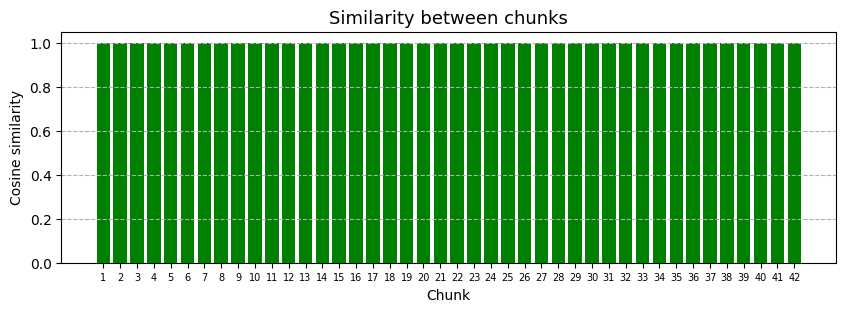

1

In [85]:
get_plot_results(df1)

### 4.2 Test 2: comparing document 1 with document2 (should be different)

In [86]:
decision2, df2 = document_comparer(document_file1, document_file2, chunks_doc1, chunks_doc2)

Comparing documents documents\Doc1.pdf and documents\Doc2.pdf:

Chunks 00001/42 are similar (cosine similarity = 1)
Chunks 00002/42 are similar (cosine similarity = 1)
Chunks 00003/42 are similar (cosine similarity = 1)
Chunks 00004/42 are similar (cosine similarity = 1)
Chunks 00005/42 are similar (cosine similarity = 1)
Chunks 00006/42 are similar (cosine similarity = 1)
Chunks 00007/42 are similar (cosine similarity = 1)
Chunks 00008/42 are similar (cosine similarity = 1)
Chunks 00009/42 are similar (cosine similarity = 1)
Chunks 00010/42 are similar (cosine similarity = 1)
Chunks 00011/42 are similar (cosine similarity = 1)
Chunks 00012/42 are similar (cosine similarity = 1)
Chunks 00013/42 are similar (cosine similarity = 1)
Chunks 00014/42 are similar (cosine similarity = 1)
Chunks 00015/42 are similar (cosine similarity = 1)
Chunks 00016/42 are similar (cosine similarity = 1)
Chunks 00017/42 are similar (cosine similarity = 1)
Chunks 00018/42 are similar (cosine similarity = 1)


In [87]:
print(f"Result: Both documents are {decision2}")

Result: Both documents are IDENTICAL


In [88]:
df2.style.map(get_df_highlight_values, subset=['SIMILARITY'])

,CHUNK_ID,DOC_1,SIZE_1,TOKENS_1,DOC_2,SIZE_2,TOKENS_2,SIMILARITY
0,1,documents\Doc1.pdf,25,9,documents\Doc2.pdf,25,9,1.000000
1,2,documents\Doc1.pdf,1371,325,documents\Doc2.pdf,1371,325,1.000000
2,3,documents\Doc1.pdf,813,169,documents\Doc2.pdf,813,169,1.000000
3,4,documents\Doc1.pdf,294,64,documents\Doc2.pdf,294,64,1.000000
4,5,documents\Doc1.pdf,505,113,documents\Doc2.pdf,505,113,1.000000
5,6,documents\Doc1.pdf,553,115,documents\Doc2.pdf,553,115,1.000000
6,7,documents\Doc1.pdf,188,40,documents\Doc2.pdf,188,40,1.000000
7,8,documents\Doc1.pdf,144,27,documents\Doc2.pdf,144,27,1.000000
8,9,documents\Doc1.pdf,339,76,documents\Doc2.pdf,339,76,1.000000
9,10,documents\Doc1.pdf,158,36,documents\Doc2.pdf,158,36,1.000000


In [89]:
excel_file = "results2.xlsx"

df2.to_excel(excel_file, index=False)

LINK = FileLink(path=excel_file)
LINK

c:\Users\chaillm\Documents\Work\training\results2.xlsx

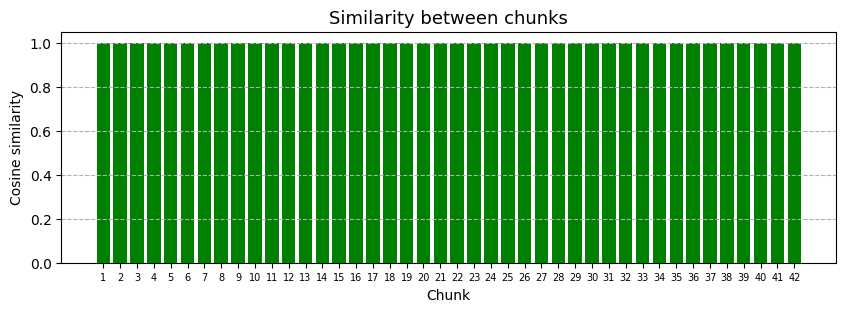

1

In [90]:
get_plot_results(df2)

### 4.3 Test 3: comparing document 1 and document 3 (different documents)

In [91]:
decision3, df3 = document_comparer(document_file1, document_file3, chunks_doc1, chunks_doc3)

Comparing documents documents\Doc1.pdf and documents\Doc3.pdf:

Chunks 00001/42 are similar (cosine similarity = 1)
Chunks 00002/42 are similar (cosine similarity = 1)
Chunks 00003/42 are similar (cosine similarity = 1)
Chunks 00004/42 are similar (cosine similarity = 1)
Chunks 00005/42 are similar (cosine similarity = 1)
Chunks 00006/42 are similar (cosine similarity = 1)
Chunks 00007/42 are similar (cosine similarity = 1)
Chunks 00008/42 are similar (cosine similarity = 1)
Chunks 00009/42 are similar (cosine similarity = 1)
Chunks 00010/42 are similar (cosine similarity = 1)
Chunks 00011/42 are similar (cosine similarity = 1)
Chunks 00012/42 are similar (cosine similarity = 1)
Chunks 00013/42 are similar (cosine similarity = 1)
Chunks 00014/42 are similar (cosine similarity = 1)
Chunks 00015/42 are similar (cosine similarity = 1)
Chunks 00016/42 are similar (cosine similarity = 1)

Chunks 00017/42 are different (cosine similarity = 0.9998)

[Differences detected]
In documents\Doc1.pd

In [92]:
print(f"Result: Both documents are {decision3}")

Result: Both documents are DIFFERENT


In [93]:
df3.style.map(get_df_highlight_values, subset=['SIMILARITY'])

,CHUNK_ID,DOC_1,SIZE_1,TOKENS_1,DOC_2,SIZE_2,TOKENS_2,SIMILARITY
0,1,documents\Doc1.pdf,25,9,documents\Doc3.pdf,25,9,1.000000
1,2,documents\Doc1.pdf,1371,325,documents\Doc3.pdf,1371,325,1.000000
2,3,documents\Doc1.pdf,813,169,documents\Doc3.pdf,813,169,1.000000
3,4,documents\Doc1.pdf,294,64,documents\Doc3.pdf,294,64,1.000000
4,5,documents\Doc1.pdf,505,113,documents\Doc3.pdf,505,113,1.000000
5,6,documents\Doc1.pdf,553,115,documents\Doc3.pdf,553,115,1.000000
6,7,documents\Doc1.pdf,188,40,documents\Doc3.pdf,188,40,1.000000
7,8,documents\Doc1.pdf,144,27,documents\Doc3.pdf,144,27,1.000000
8,9,documents\Doc1.pdf,339,76,documents\Doc3.pdf,339,76,1.000000
9,10,documents\Doc1.pdf,158,36,documents\Doc3.pdf,158,36,1.000000


In [94]:
excel_file = "results3.xlsx"

df3.to_excel(excel_file, index=False)

LINK = FileLink(path=excel_file)
LINK

c:\Users\chaillm\Documents\Work\training\results3.xlsx

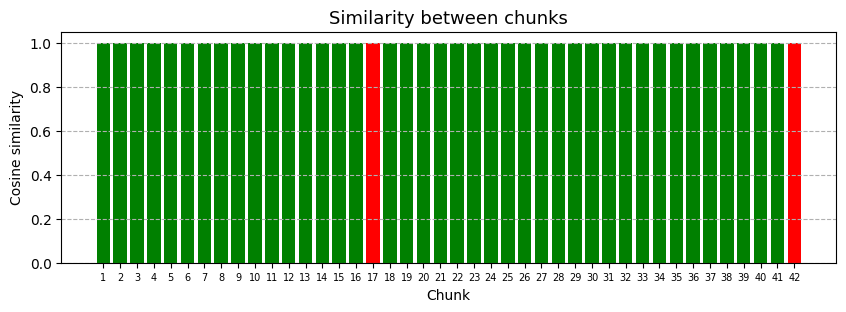

Number of different chunk(s) = 2

 CHUNK_ID              DOC_1  SIZE_1  TOKENS_1              DOC_2  SIZE_2  TOKENS_2  SIMILARITY
       17 documents\Doc1.pdf    8875      2001 documents\Doc3.pdf    8875      2002      0.9998
       42 documents\Doc1.pdf    5162      1163 documents\Doc3.pdf    5162      1163      0.9998

Weighted average of SIMILARITY = 0.9999531536867042


0.9999531536867042

In [95]:
get_plot_results(df3)